In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import mode

from get_model_training_data_05 import get_features_and_data

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def precision_and_recall(df, true_col="release", pred_col="release_pred"):
    true_positives = len(df[(df[true_col] == 1) & (df[pred_col] == 1)])
    false_positives = len(df[(df[true_col] != 1) & (df[pred_col] == 1)])
    false_negatives = len(df[(df[true_col] == 1) & (df[pred_col] != 1)])

    return (np.round(true_positives / (true_positives + false_positives), 3),
            np.round(true_positives / (true_positives + false_negatives), 3))

## Load Training and Testing Data

In [4]:
(df, train_df, test_df, feature_names, next_two_weeks) = get_features_and_data()

training examples = 2500, testing examples = 327


In [5]:
feature_names

['days_since_previous_release',
 'month_holidays',
 'WD_Monday',
 'WD_Saturday',
 'WD_Sunday',
 'WD_Thursday',
 'WD_Tuesday',
 'WD_Wednesday',
 'previous_release']

In [6]:
train_df["release"].value_counts()

release
0    2150
1     350
Name: count, dtype: Int64

In [7]:
train_df.groupby(["year", "release"]).size().reset_index().pivot(index="year", columns="release", values=0)

release,0,1
year,,
2017,270,39
2018,323,42
2019,312,53
2020,320,46
2021,310,55
2022,308,57
2023,307,58


## Model-Building and Evaluation

In [8]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    # linear model
    release_prob = pm.math.invlogit(beta0 + pm.math.dot(weights, features))
    release = pm.Bernoulli(
        "release",
        p=release_prob,
        observed=train_df["release"].values,
        shape=features.shape[1],
    )

In [9]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [10]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,0.18,0.02,0.15,0.22,0.00,0.00,2851.26,2172.89,1.0
month_holidays,0.03,0.05,-0.06,0.13,0.00,0.00,3375.96,2712.42,1.0
WD_Thursday,-0.11,0.18,-0.44,0.24,0.00,0.00,2644.43,2841.04,1.0
WD_Wednesday,-0.39,0.19,-0.75,-0.03,0.00,0.00,2617.01,3059.08,1.0
WD_Saturday,-0.56,0.20,-0.92,-0.15,0.00,0.00,2546.25,2683.34,1.0
WD_Tuesday,-0.93,0.21,-1.29,-0.50,0.00,0.00,2615.88,2424.49,1.0
WD_Sunday,-1.21,0.23,-1.63,-0.76,0.00,0.00,2830.41,2728.04,1.0
previous_release,-1.63,0.40,-2.33,-0.87,0.01,0.01,3846.06,2169.02,1.0
WD_Monday,-1.64,0.25,-2.12,-1.17,0.00,0.00,3065.98,2961.01,1.0


### Out-of-Sample Evaluation

In [11]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["release"])

Sampling: [release]


Output()

In [12]:
test_df["release_pred"] = [mode(p)[0] for p in pred_test["predictions"]["release"].stack(all_draws=["chain", "draw"]).values]

In [13]:
test_df["release_pred"].value_counts()

release_pred
0    327
Name: count, dtype: int64

In [14]:
test_df["release"].value_counts()

release
0    270
1     57
Name: count, dtype: Int64

In [15]:
precision_and_recall(test_df)

ZeroDivisionError: division by zero

In [16]:
test_df["release_pred_prob"] = np.mean(pred_test["predictions"]["release"].stack(all_draws=["chain", "draw"]).values, axis=1)

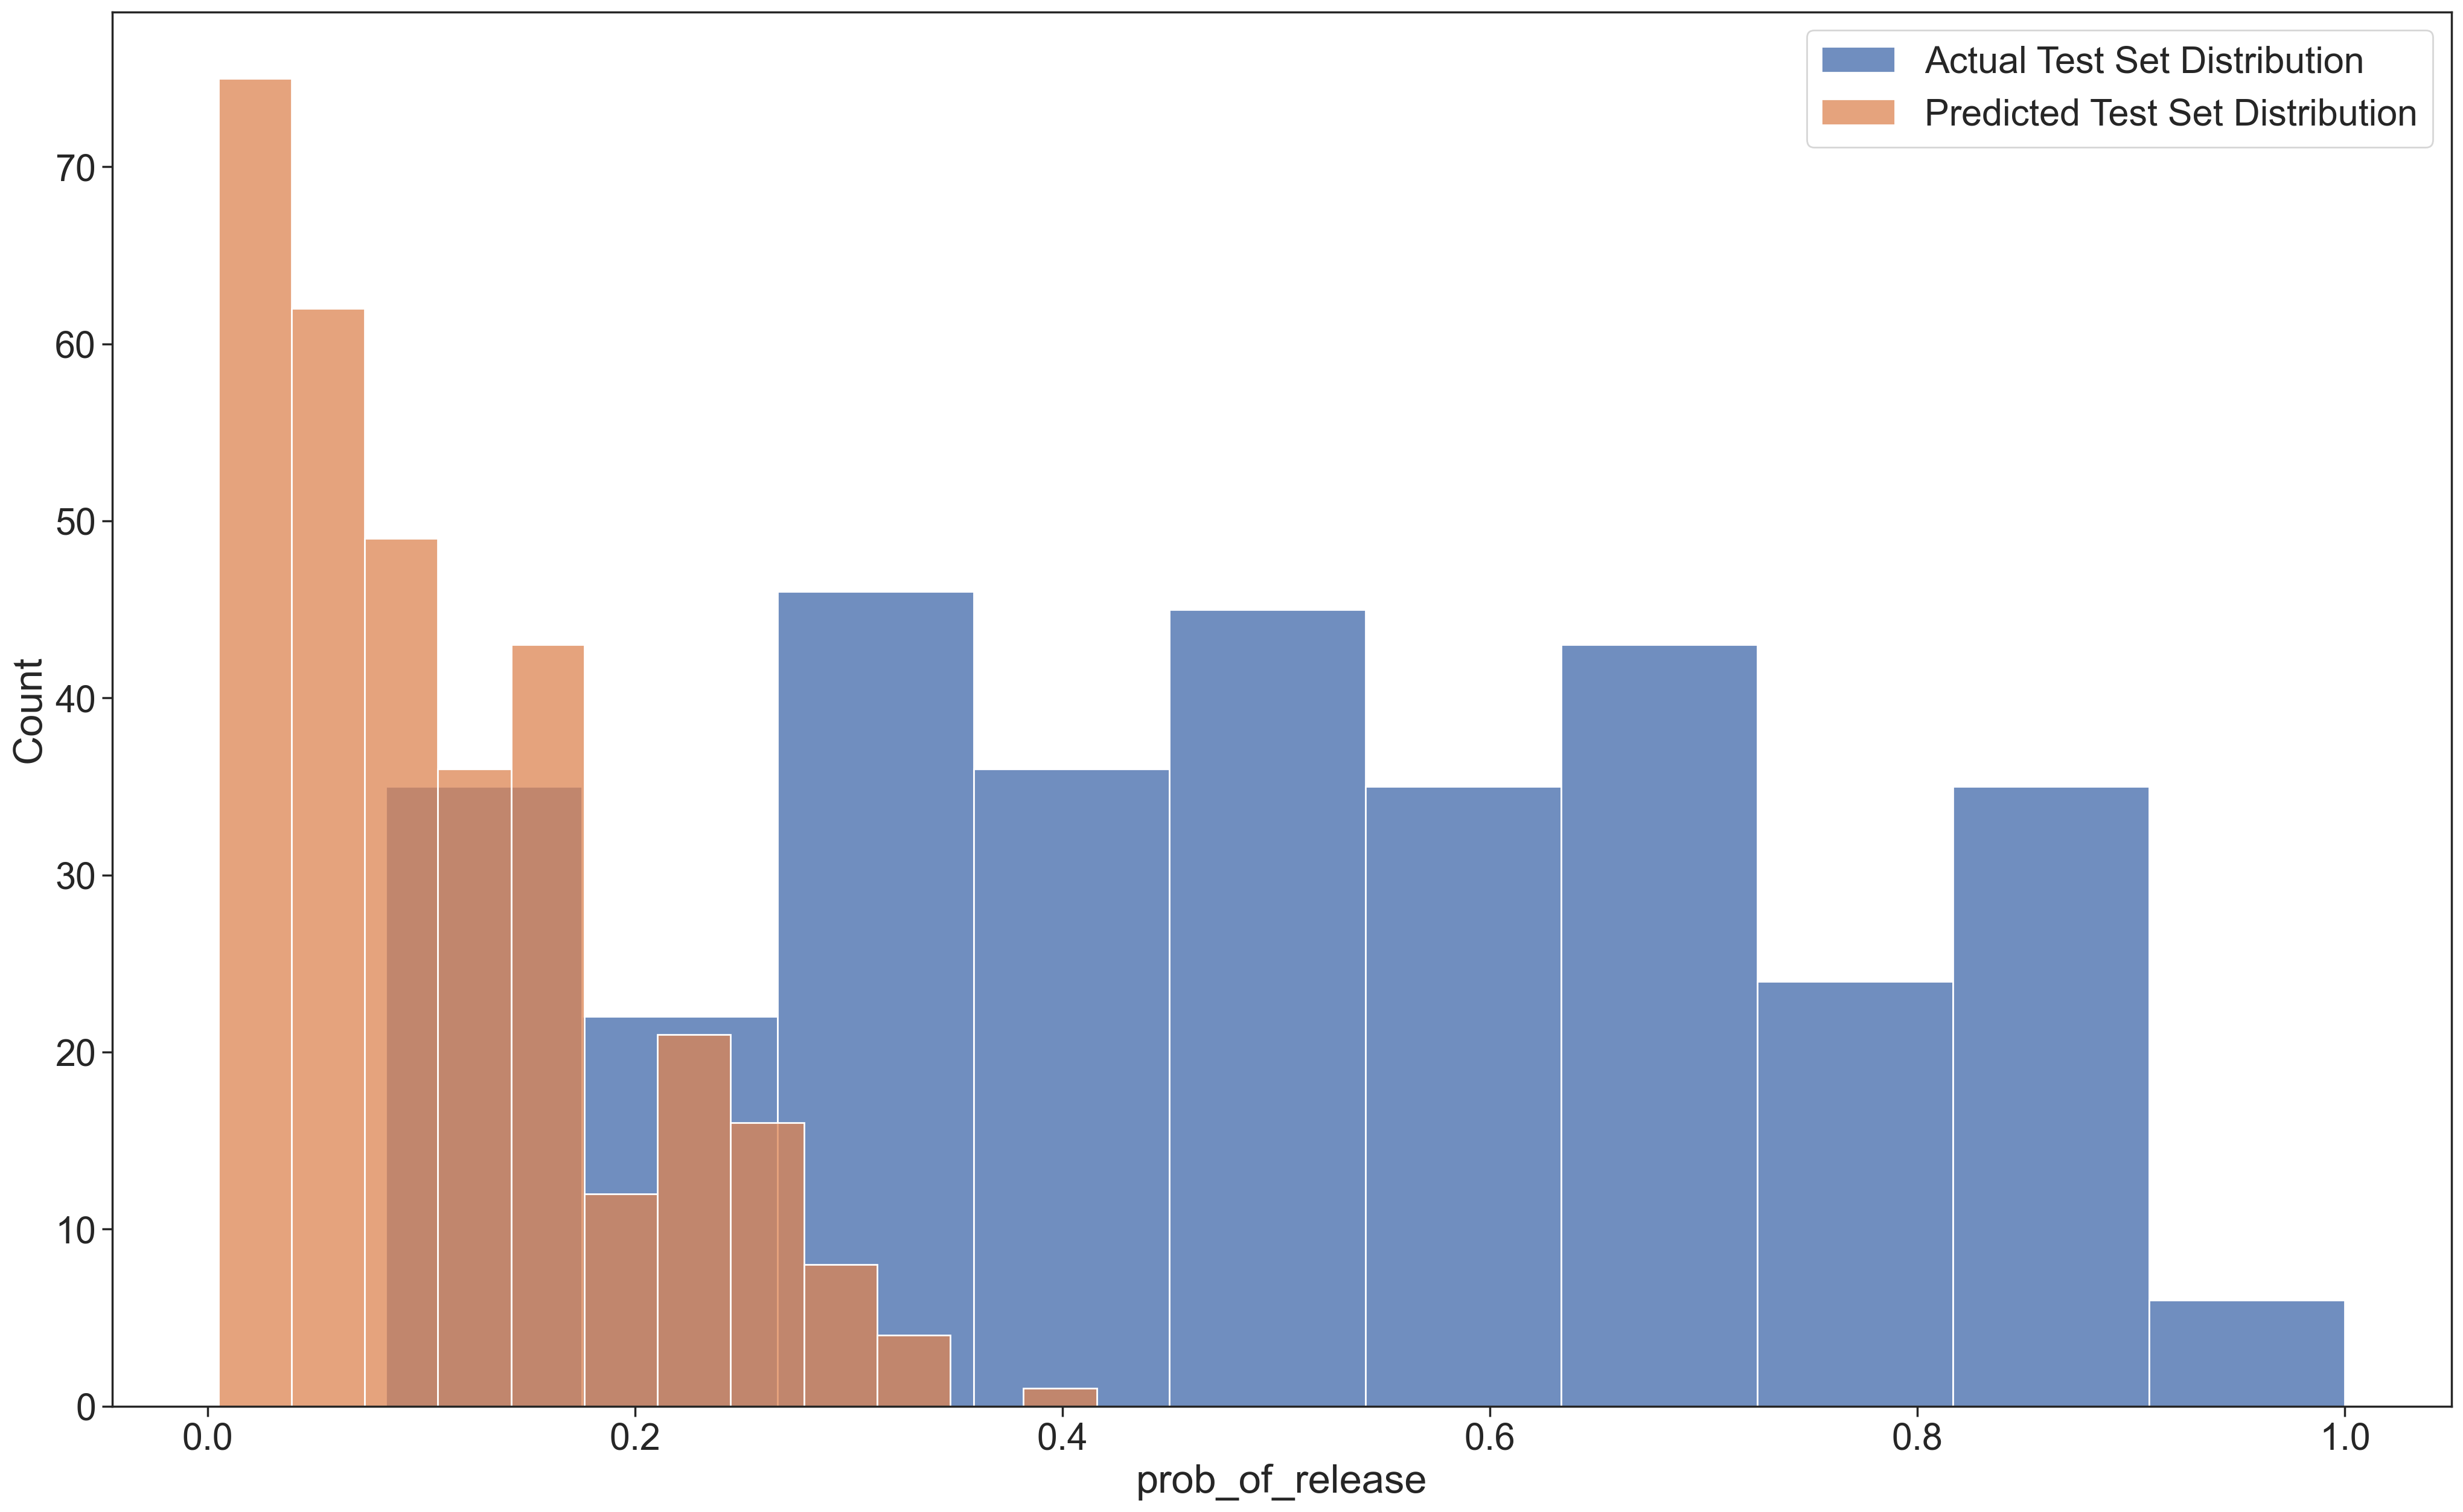

In [17]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=test_df["release_pred_prob"], ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()